# <p style="text-align: center;">Road Anomoly Detection Using CNN</p>


## TEAM MEMBERS:-
Tanzil         (21BIT0292).  
Tarunika Aggarwal(21BIT0442).  
Arnav jain(21BIT0712)

### **1. Import the Required Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [ ]:
import zipfile
import os

# Unzip the dataset
dataset_zip_path = '/content/Road_Anomaly_Dataset.zip'  # path to the zipped dataset
unzip_dir = '/content/Road_Anomaly_Datase'  # directory to unzip to

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Define paths to the training and validation datasets
train_dataset_path = os.path.join(unzip_dir, 'train')
validation_dataset_path = os.path.join(unzip_dir, 'val')

print(f"Training dataset path: {train_dataset_path}")
print(f"Validation dataset path: {validation_dataset_path}")


Training dataset path: /content/Road_Anomaly_Datase/train
Validation dataset path: /content/Road_Anomaly_Datase/val


In [ ]:
# List contents of the unzipped directory
print("Contents of unzip_dir:", os.listdir(unzip_dir))


Contents of unzip_dir: ['__MACOSX', 'Road_Anomaly_Dataset']


In [ ]:
extracted_folder = os.path.join(unzip_dir, 'Road_Anomaly_Dataset')  # Adjust based on the unzipped folder name

# Now update the paths to train and validation datasets
train_dataset_path = os.path.join(extracted_folder, 'train')
validation_dataset_path = os.path.join(extracted_folder, 'val')

print(f"Training dataset path: {train_dataset_path}")
print(f"Validation dataset path: {validation_dataset_path}")


Training dataset path: /content/Road_Anomaly_Datase/Road_Anomaly_Dataset/train
Validation dataset path: /content/Road_Anomaly_Datase/Road_Anomaly_Dataset/val


#### **ii. Load Image Datasets and Apply Augmentations**

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [ ]:
import os

# Verify if the train directory exists
if os.path.exists(train_dataset_path):
    print("Train dataset path exists.")
    print("Contents of train directory:", os.listdir(train_dataset_path))
else:
    print("Train dataset path does NOT exist.")


Train dataset path exists.
Contents of train directory: ['Fight', 'Fire', 'Accident', 'Snatching']


In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2635 images belonging to 4 classes.


Loading the validation dataset.

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 139 images belonging to 4 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Accident
1 : Fight
2 : Fire
3 : Snatching


### **3. Plotting Sample Training Images**

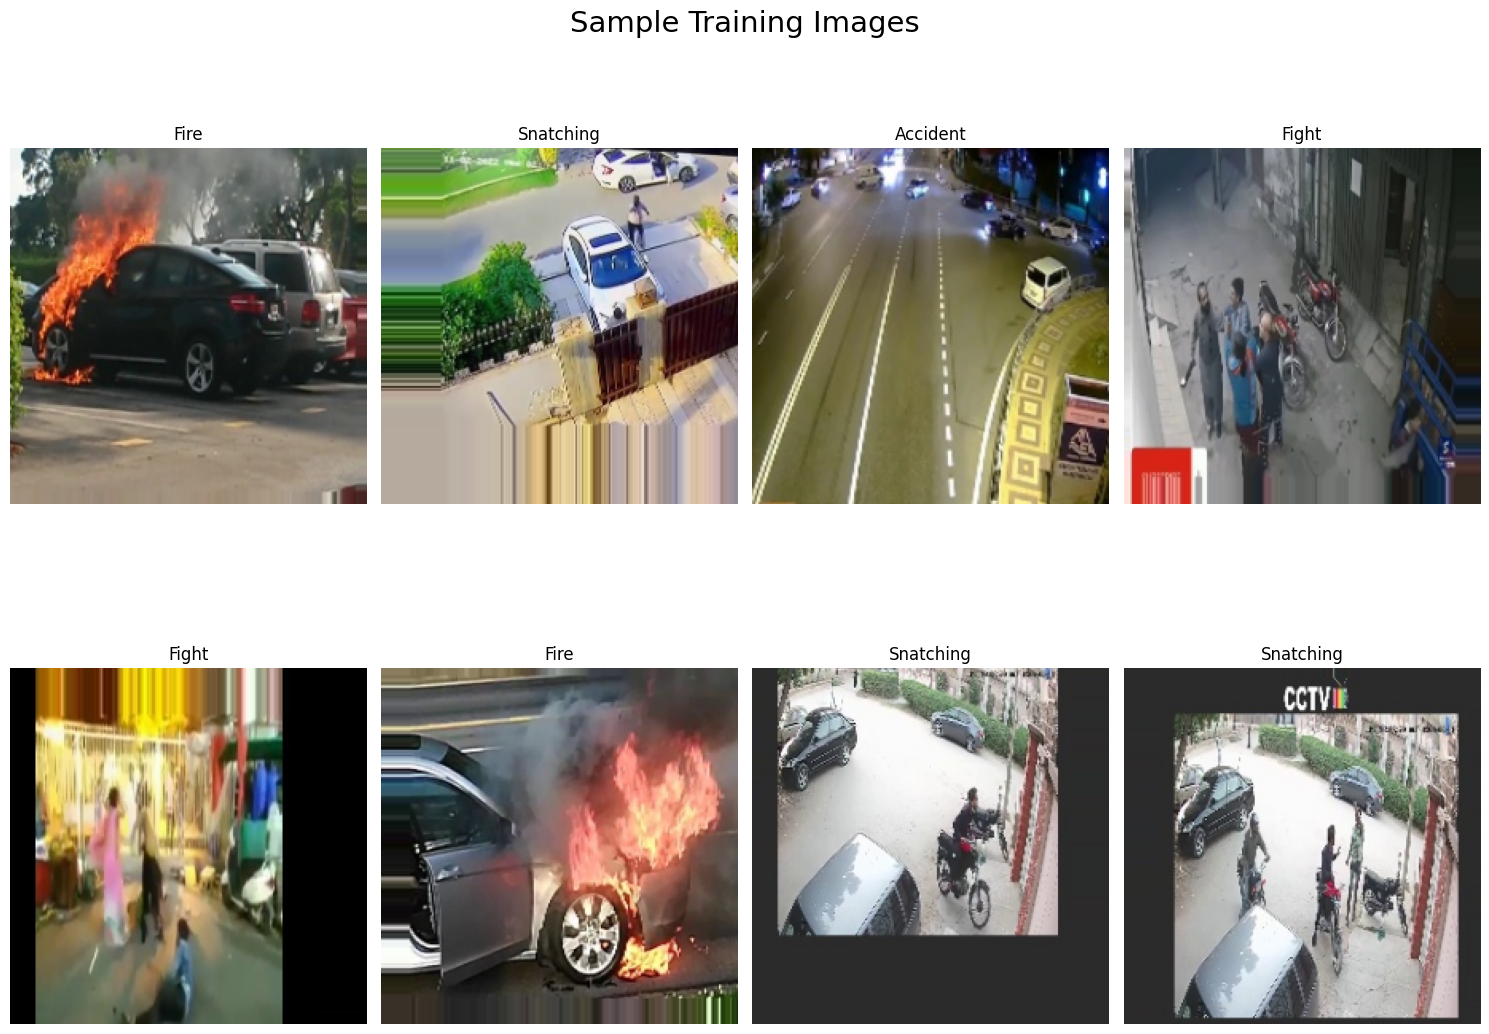

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

#### **i. Create a CNN Model**

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])

    return model

In [ ]:
cnn_model = load_model('my_model.h5') #Load pre-trained model

In [ ]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 220, 220, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 110, 110, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 108, 108, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,641,958 (21.52 MB)

 Trainable params: 5,641,508 (21.52 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

None


#### **ii. Defining Callbacks**

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [ ]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


#### **v. Training and saving the Model (iteratively)**

In [ ]:
for i in range(2,4):
  history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                        verbose=2,
                        callbacks=[reduce_lr])
  model_name = "my_model_" + str(i) + ".h5" # Saving the model in .h5 file format so it can be used for UI design
  cnn_model.save(model_name)
  cnn_model = load_model(model_name)
  optimizer = Adam(learning_rate=0.001) # re-initialize the optimizer
  cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy']) # re-compile

Epoch 1/50
83/83 - 57s - 686ms/step - accuracy: 0.9939 - loss: 0.1458 - val_accuracy: 1.0000 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 2/50
83/83 - 61s - 736ms/step - accuracy: 0.9954 - loss: 0.1219 - val_accuracy: 1.0000 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 3/50
83/83 - 40s - 482ms/step - accuracy: 0.9917 - loss: 0.2698 - val_accuracy: 1.0000 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/50
83/83 - 34s - 409ms/step - accuracy: 0.9954 - loss: 0.1194 - val_accuracy: 0.9496 - val_loss: 1.2825 - learning_rate: 0.0010
Epoch 5/50
83/83 - 40s - 487ms/step - accuracy: 0.9886 - loss: 0.3659 - val_accuracy: 0.8633 - val_loss: 9.2768 - learning_rate: 0.0010
Epoch 6/50
83/83 - 41s - 498ms/step - accuracy: 0.9917 - loss: 0.1765 - val_accuracy: 1.0000 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 7/50
83/83 - 32s - 388ms/step - accuracy: 0.9970 - loss: 0.0886 - val_accuracy: 1.0000 - val_loss: 0.0102 - learning_rate: 3.1623e-04
Epoch 8/50
83/83 - 43s - 513ms/step - accura

Epoch 1/50
83/83 - 44s - 525ms/step - accuracy: 0.9962 - loss: 0.1459 - val_accuracy: 1.0000 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 2/50
83/83 - 74s - 894ms/step - accuracy: 0.9958 - loss: 0.0739 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 3/50
83/83 - 41s - 500ms/step - accuracy: 0.9951 - loss: 0.0815 - val_accuracy: 1.0000 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 4/50
83/83 - 40s - 487ms/step - accuracy: 0.9920 - loss: 0.1933 - val_accuracy: 0.7482 - val_loss: 24.0628 - learning_rate: 0.0010
Epoch 5/50
83/83 - 41s - 497ms/step - accuracy: 0.9913 - loss: 0.2124 - val_accuracy: 0.9640 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 6/50
83/83 - 33s - 396ms/step - accuracy: 0.9928 - loss: 0.1343 - val_accuracy: 0.8561 - val_loss: 2.4624 - learning_rate: 0.0010
Epoch 7/50
83/83 - 42s - 508ms/step - accuracy: 0.9970 - loss: 0.0797 - val_accuracy: 1.0000 - val_loss: 0.0091 - learning_rate: 3.1623e-04
Epoch 8/50
83/83 - 33s - 399ms/step - accur

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history.get('lr', [])


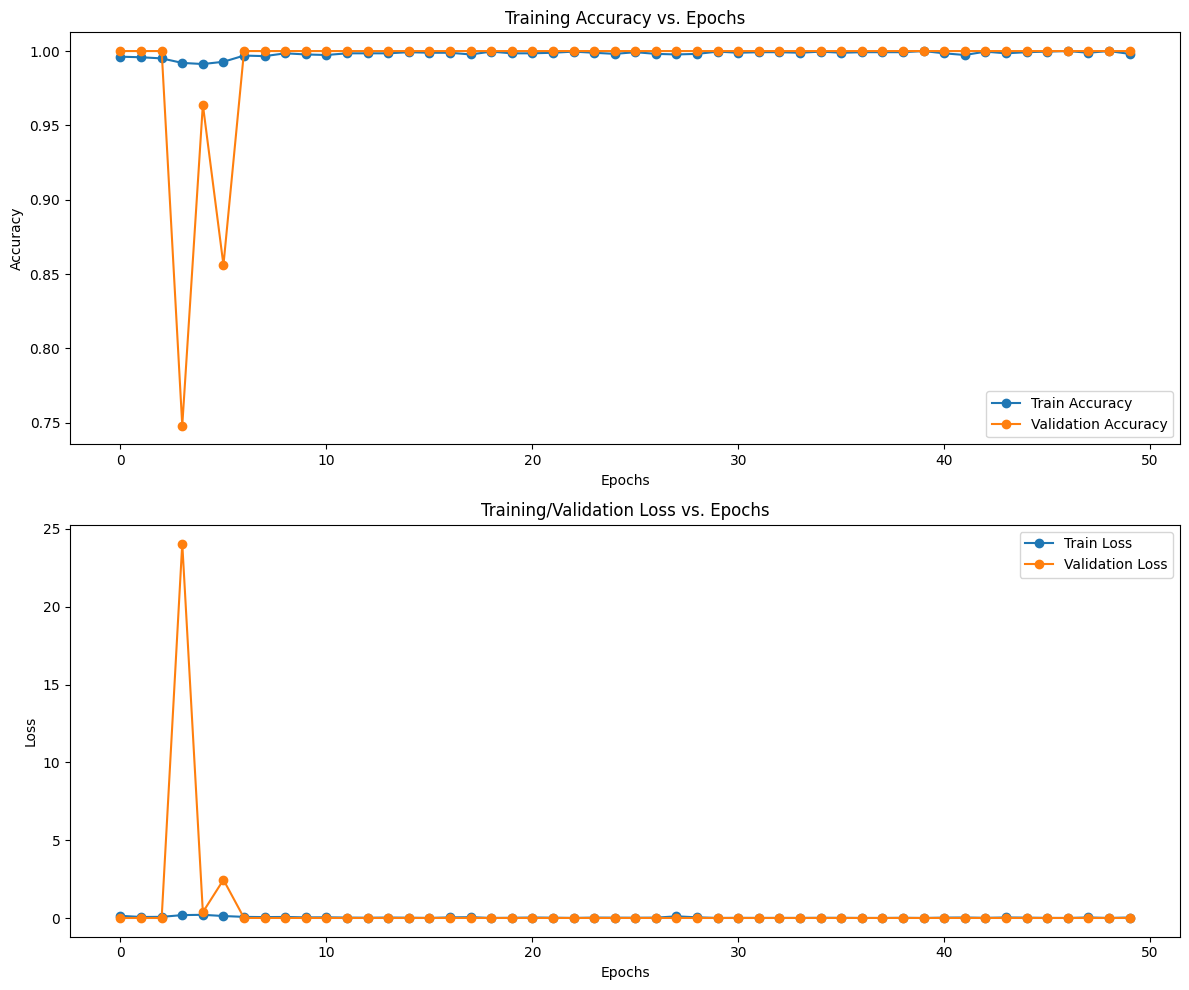

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')s

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

In [ ]:
import zipfile
import os

# Unzip the dataset
dataset_zip_path = '/content/Road_Anomaly_Dataset.zip'  # Path to the zipped dataset
unzip_dir = '/content'  # Directory to unzip to

# Extract the dataset
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Assuming that the dataset is unzipped into a folder called 'Road_Anomaly_Dataset'
extracted_folder = os.path.join(unzip_dir, 'Road_Anomaly_Dataset')  # Adjust based on the unzipped folder name

# Update the paths to train, validation, and test datasets
train_dataset_path = os.path.join(extracted_folder, 'train')
validation_dataset_path = os.path.join(extracted_folder, 'val')
test_dataset_path = os.path.join(extracted_folder, 'test')

# Print the paths to verify
print(f"Training dataset path: {train_dataset_path}")
print(f"Validation dataset path: {validation_dataset_path}")
print(f"Test dataset path: {test_dataset_path}")

# Verify if the paths exist
if os.path.exists(train_dataset_path):
    print("Train dataset directory exists.")
else:
    print("Train dataset directory does NOT exist.")

if os.path.exists(validation_dataset_path):
    print("Validation dataset directory exists.")
else:
    print("Validation dataset directory does NOT exist.")

if os.path.exists(test_dataset_path):
    print("Test dataset directory exists.")
else:
    print("Test dataset directory does NOT exist.")



Training dataset path: /content/Road_Anomaly_Dataset/train
Validation dataset path: /content/Road_Anomaly_Dataset/val
Test dataset path: /content/Road_Anomaly_Dataset/test
Train dataset directory exists.
Validation dataset directory exists.
Test dataset directory exists.


In [ ]:
test_dataset = '/content/Road_Anomaly_Dataset/test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 645 images belonging to 4 classes.


### **7. Model Prediction on the Test Dataset**

In [ ]:
predictions = cnn_model.predict(test_generator)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


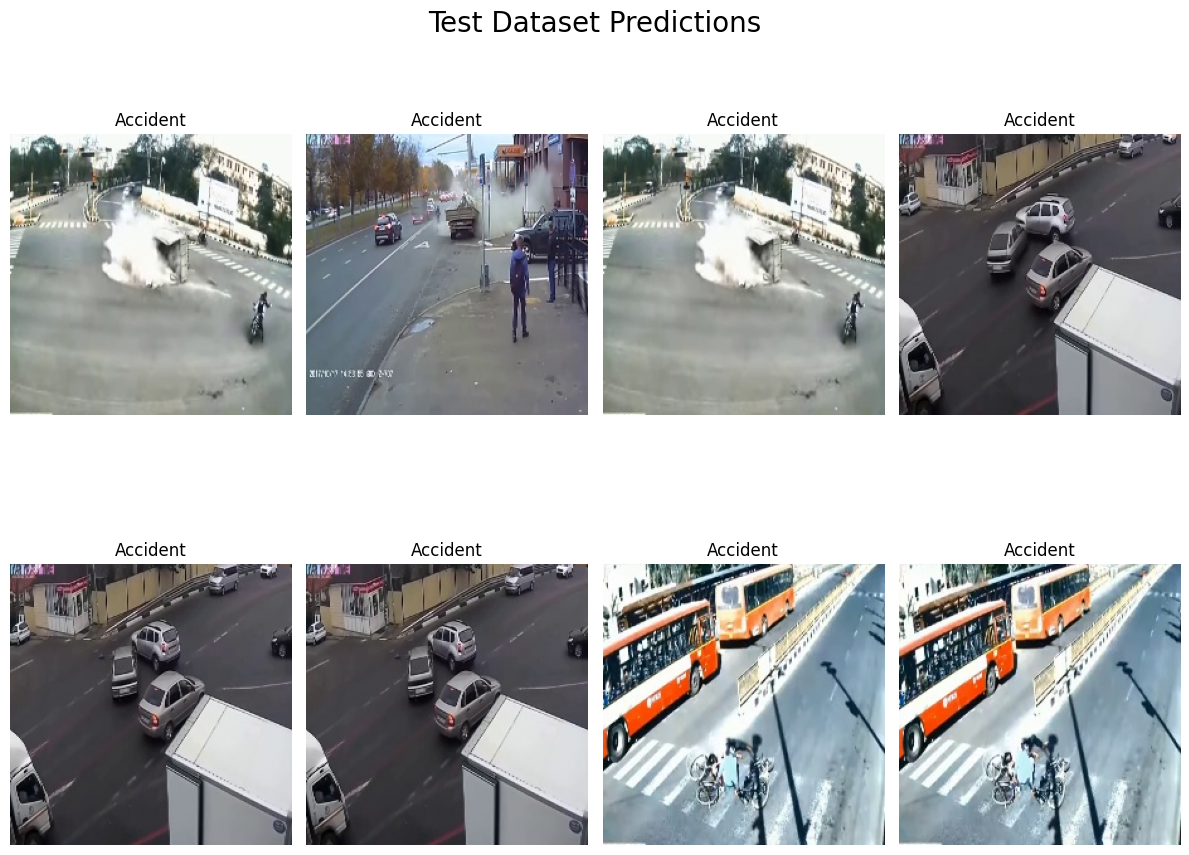

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 0.0089
Test Loss:     0.008886038325726986
Test Accuracy: 1.0


### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

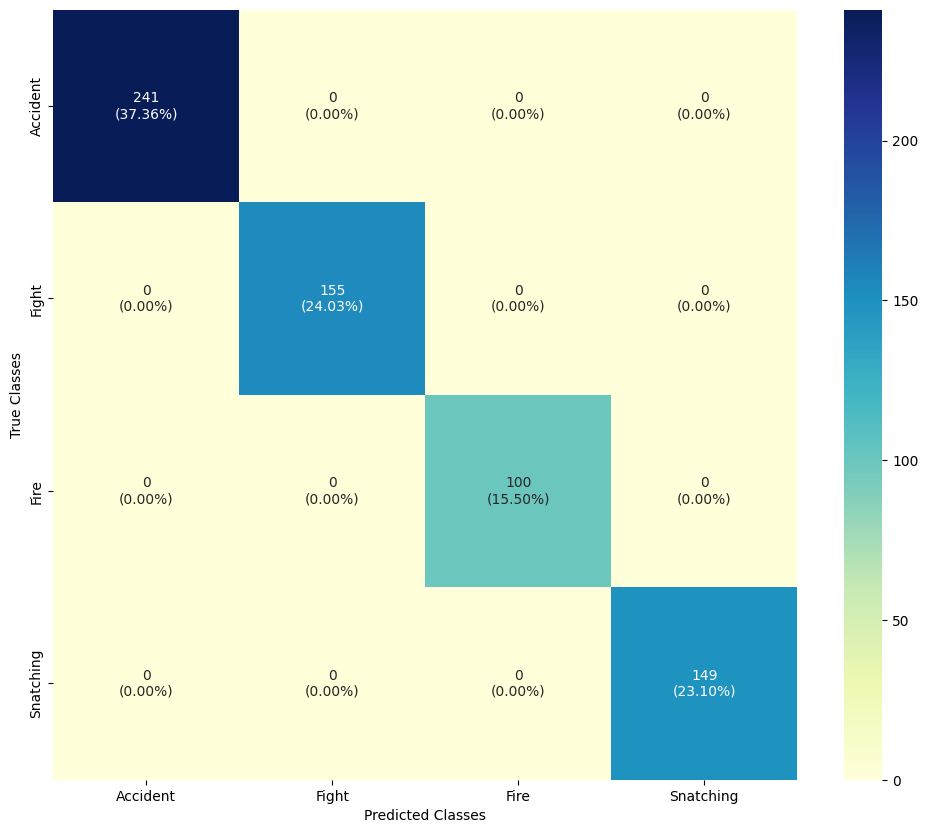

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

    Accident       1.00      1.00      1.00       241
       Fight       1.00      1.00      1.00       155
        Fire       1.00      1.00      1.00       100
   Snatching       1.00      1.00      1.00       149

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [ ]:
# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
# idx = 0

# for i in range(2):
#     for j in range(4):
#         idx = np.random.randint(0, len(test_img))
#         true_index = y_true_errors[idx]
#         true_label = labels[true_index]
#         predicted_index = y_pred_errors[idx]
#         predicted_label = labels[predicted_index]
#         ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
#         img_path = os.path.join(test_dataset, test_img[idx])
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         ax[i, j].imshow(img)
#         ax[i, j].axis("off")

# plt.tight_layout()
# plt.suptitle('Wrong Predictions made on test set', fontsize=20)
# plt.show()